<a href="https://colab.research.google.com/github/yrodriguezmd/Deep_Learning_tutorials/blob/main/01_Series_vs_One_time_Learning_vf_tutorial_nov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11 master

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import icevision

In [ ]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.11.0
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


In [ ]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

**Set_1**




Load raw images Set_1

In [ ]:
!ls Surgical_instruments/Sets/Set_1/annotated

README.dataset.txt  README.roboflow.txt  test  train  valid


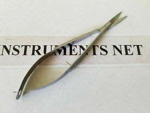

In [ ]:
image_path = Path('Surgical_instruments/Sets/Set_1/annotated')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[100]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
# using project-specific classes
# 15 classes + background
classes = ['Army_navy', 'Bulldog', 'Castroviejo','Forceps', 'Frazier', 'Hemostat','Iris','Mayo_metz','Needle','Potts','Richardson','Scalpel','Towel_clip', 'Weitlaner','Yankauer']
class_map = ClassMap(classes)
len(class_map)

16

Parse Data

In [ ]:
path = Path('Surgical_instruments/Sets/Set_1/annotated') 

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',##
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

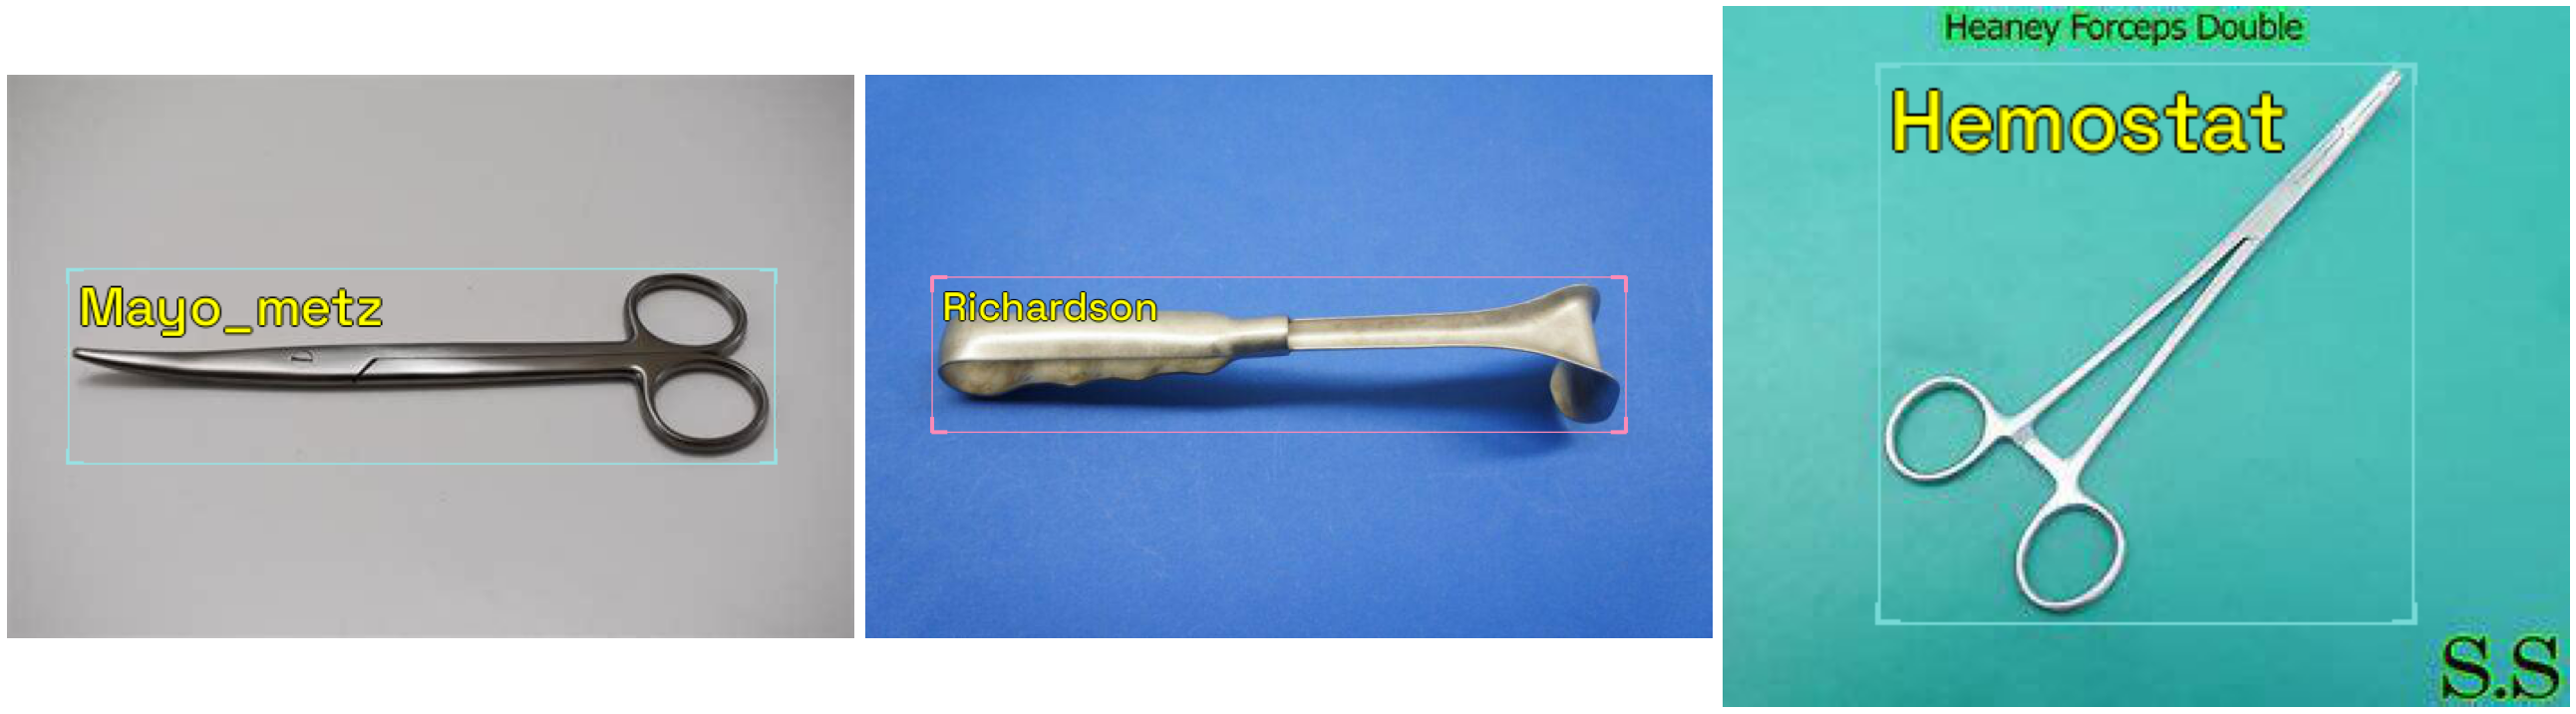

In [ ]:
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

Transforms and Dataset

In [ ]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Model

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map),)# **extra_args)

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [ ]:
from fastai.callback.wandb import *

wandb.init(project = 'Transfer_learning_vf', name = 'Series', ##
           reinit = True)

In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.0003311311302240938)

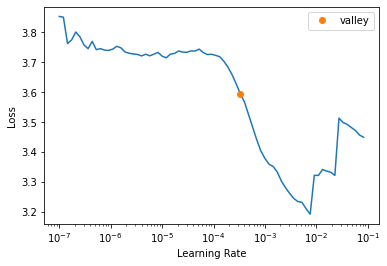

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(30, 3e-04) #vf

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,3.688529,3.414950,0.000000,00:10


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,3.416109,3.471557,0.000000,00:10
1,3.263390,3.138845,0.081669,00:08
2,3.088634,2.658238,0.124768,00:09
3,2.878691,2.280782,0.170825,00:09
4,2.669440,2.247748,0.205641,00:09
5,2.499078,2.034733,0.266113,00:09
6,2.359165,2.058639,0.258337,00:09
7,2.250688,2.037049,0.331450,00:09
8,2.158930,2.196274,0.268612,00:09
9,2.080145,2.184689,0.196417,00:09


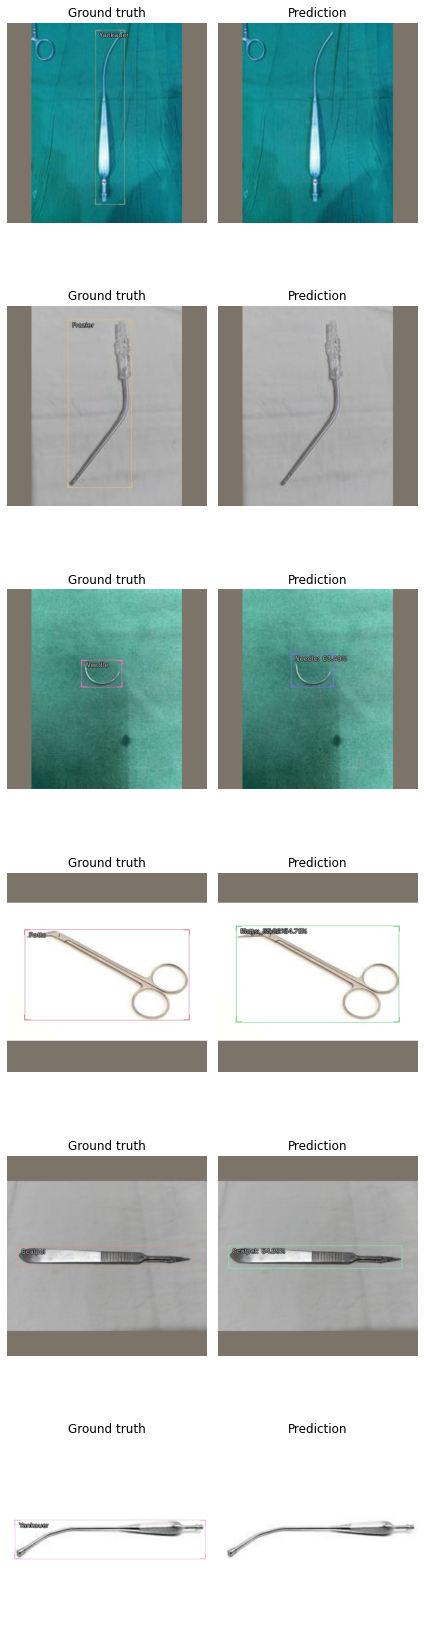

In [ ]:
model_type.show_results(model, valid_ds) #Set_1

Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

root_dir = Path('/content/gdrive/My Drive/Surgical_instruments/Models/')

Mounted at /content/gdrive


In [ ]:
from icevision.models import *

checkpoint_path = root_dir/'Model_1.pth' #

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet', #
                        backbone_name='resnet50_fpn_mstrain_2x',#
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path),#
                        meta={'icevision_version': '0.9.1'})

**Set_2**

In [ ]:
path = Path('Surgical_instruments/Sets/Set_2/annotated') 

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',##
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

In [ ]:
# same classes, sizes and transformations
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Utilize previously trained model

In [ ]:
checkpoint_path = root_dir/'Model_1.pth' #

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [ ]:
# same metric and model structure
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [ ]:
#from fastai.callback.wandb import *

#wandb.init(project = 'Transfer_learning_', name = 'Series', ##
#           reinit = True)

In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.00013182566908653826)

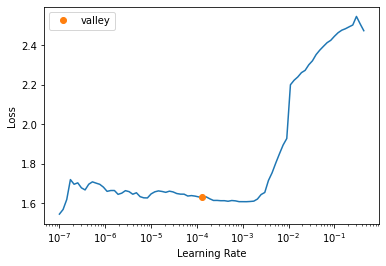

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(30, 1e-04) # Set_2

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,1.686551,1.832600,0.544334,00:08


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.631782,1.824239,0.550347,00:09
1,1.584958,1.852440,0.535541,00:09
2,1.565081,1.864306,0.535753,00:09
3,1.547991,1.828051,0.557757,00:09
4,1.515893,1.787489,0.563942,00:09
5,1.481488,1.773235,0.572702,00:09
6,1.461723,1.777144,0.585388,00:09
7,1.436023,1.786956,0.565868,00:09
8,1.415839,1.781129,0.567445,00:09
9,1.389954,1.799364,0.588532,00:09


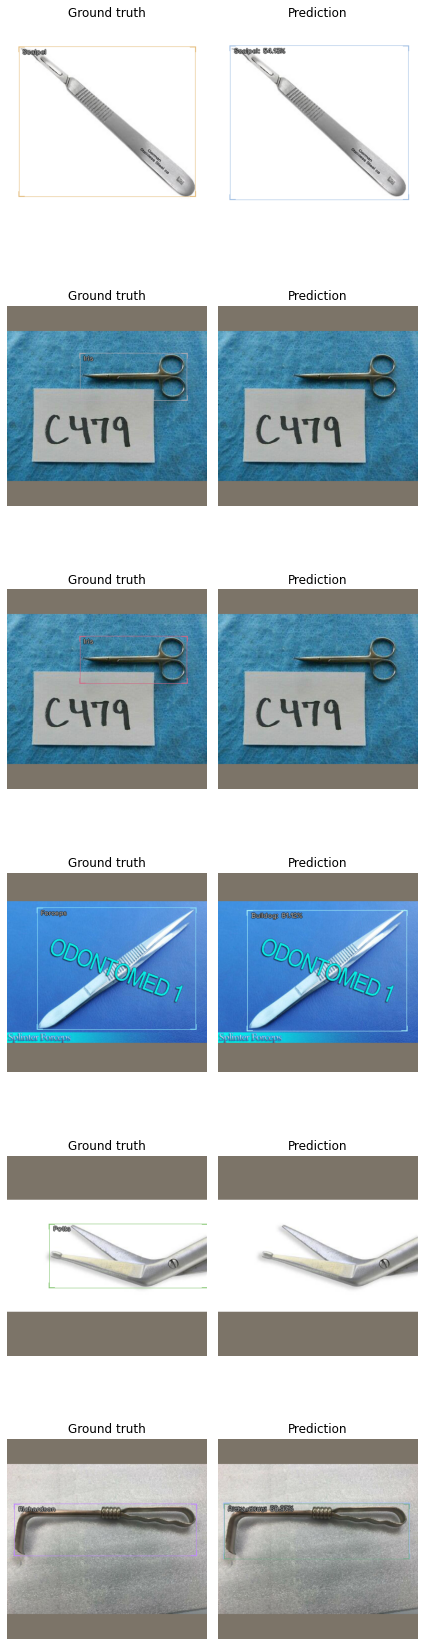

In [ ]:
model_type.show_results(model, valid_ds)

In [ ]:
checkpoint_path = root_dir/'Model_2.pth'#

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet', #
                        backbone_name='resnet50_fpn_mstrain_2x',#
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path),
                        meta={'icevision_version': '0.9.1'})

**Set_3**

In [ ]:
path = Path('Surgical_instruments/Sets/Set_3/annotated') 

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',##
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

In [ ]:
# same classes, sizes and transformations
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
# utilize previously trained model
checkpoint_path = root_dir/'Model_2.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [ ]:
# same metric and model structure
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [ ]:
#wandb.init(project = 'Transfer_learning', name = 'Series', ##
#           reinit = True)

In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=7.585775892948732e-05)

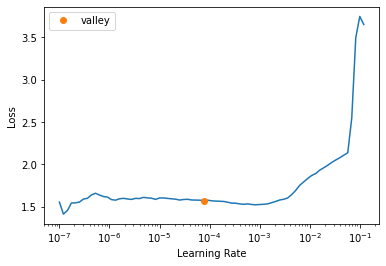

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(30,1e-04) #Set_3

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,1.618725,1.396002,0.659437,00:09


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.521578,1.370676,0.667837,00:09
1,1.477110,1.355726,0.668204,00:09
2,1.494495,1.351004,0.675725,00:09
3,1.470261,1.333952,0.681264,00:09
4,1.447436,1.328129,0.707506,00:09
5,1.424937,1.306320,0.700414,00:09
6,1.400364,1.373697,0.665730,00:09
7,1.370017,1.323498,0.687601,00:09
8,1.339059,1.309763,0.690214,00:09
9,1.319487,1.287255,0.707972,00:09


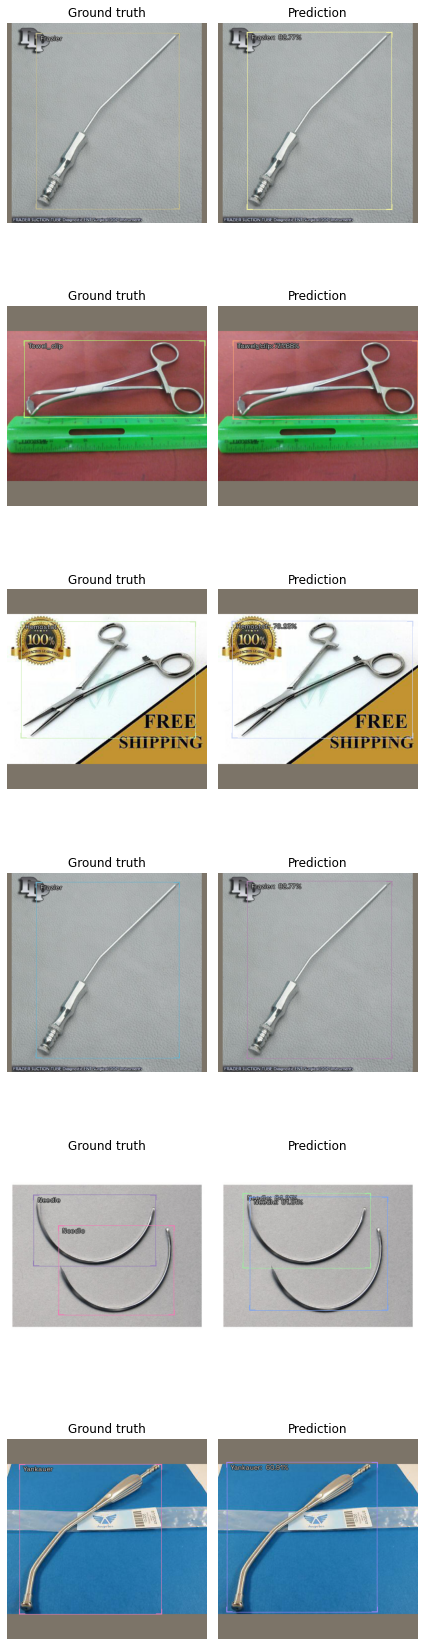

In [ ]:
model_type.show_results(model, valid_ds) #Set_3

In [ ]:
checkpoint_path = root_dir/'Model_3.pth'#

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path),
                        meta={'icevision_version': '0.9.1'})

**Set_4**

In [ ]:
path = Path('Surgical_instruments/Sets/Set_4/annotated') 

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',##
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

In [ ]:
# same classes, sizes and transformations
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
# utilize previously trained model
checkpoint_path = root_dir/'Model_3.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [ ]:
# same metric and model structure
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [ ]:
#wandb.init(project = 'Transfer_learning', name = 'Series', ##
#           reinit = True)

In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=9.120108734350652e-05)

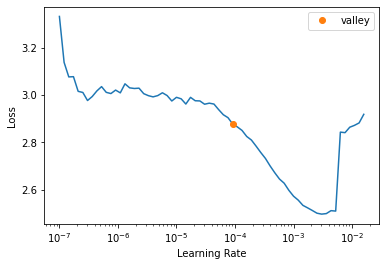

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(30,1e-04) #Set_4

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,2.982549,2.844457,0.183104,00:08


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,2.650103,2.726310,0.197593,00:09
1,2.603501,2.619061,0.216005,00:09
2,2.501904,2.514108,0.235231,00:09
3,2.416742,2.389240,0.258830,00:09
4,2.317456,2.248079,0.281820,00:09
5,2.206036,2.082672,0.334497,00:09
6,2.109196,2.001610,0.347736,00:09
7,2.008182,1.931255,0.376310,00:09
8,1.919470,1.897691,0.401702,00:09
9,1.847660,1.905707,0.372917,00:09


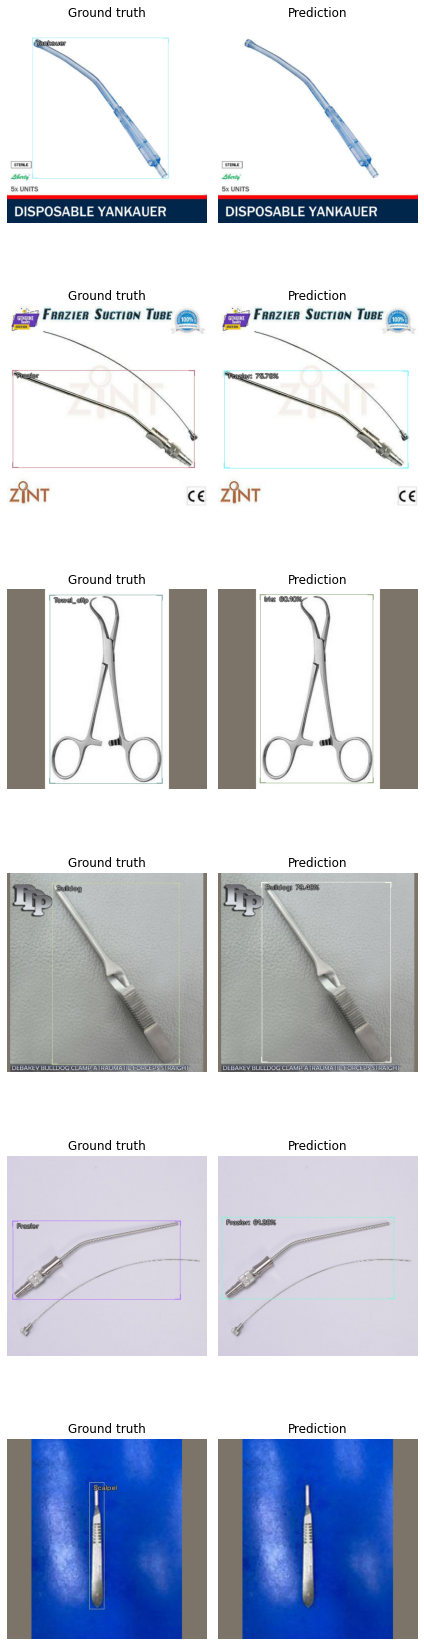

In [ ]:
model_type.show_results(model, valid_ds)

In [ ]:
checkpoint_path = root_dir/'Model_4.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path),
                        meta={'icevision_version': '0.9.1'})

**Set_5**

In [ ]:
# set 5 checked resolved mayo-metz
path = Path('gdrive/MyDrive/Surgical_instruments/Set_5.v2i.coco')

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',##
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

In [ ]:
# same classes, sizes and transformations

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
# utilize previously trained model
checkpoint_path = root_dir/'Model_4.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [ ]:
# same metric and model structure

train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [ ]:
#wandb.init(project = 'Transfer_learning', name = 'Series', reinit = True)

In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,
                                 cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.00019054606673307717)

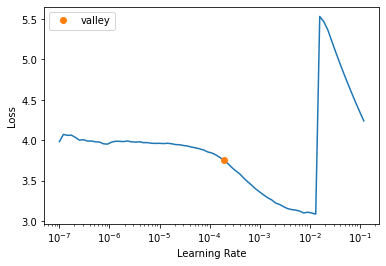

In [ ]:
# error resolved with resolution of annotation for mayo-metz
learn.lr_find() #Set_5

In [ ]:
learn.fine_tune(30,5e-04) #Set_5

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,3.627220,2.759580,0.153301,00:08


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,2.264134,2.274732,0.204160,00:09
1,2.116849,2.029011,0.193442,00:09
2,1.995326,1.930630,0.286876,00:09
3,1.920459,1.883285,0.312524,00:09
4,1.834109,1.827620,0.347855,00:09
5,1.773749,1.790010,0.381793,00:09
6,1.706664,1.765220,0.363783,00:09
7,1.651321,1.796292,0.345804,00:09
8,1.607304,1.810978,0.398170,00:09
9,1.576829,1.766390,0.418099,00:09


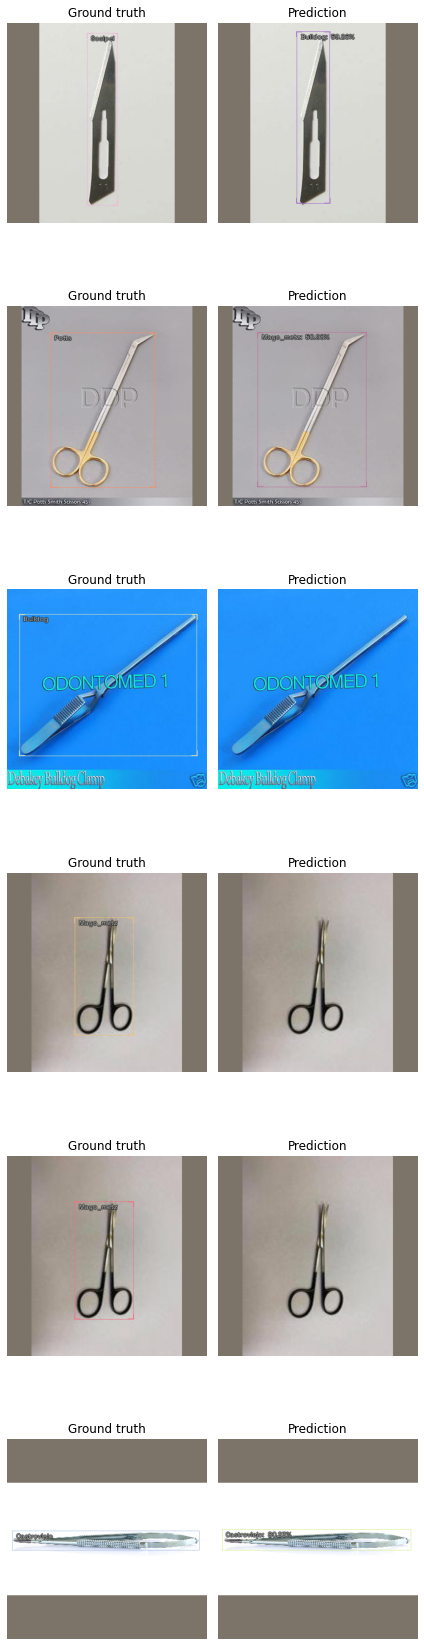

In [ ]:
model_type.show_results(model, valid_ds)

In [ ]:
checkpoint_path = root_dir/'Model_5.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path),
                        meta={'icevision_version': '0.9.1'})

**Set_6**

In [ ]:
!ls gdrive/MyDrive/Surgical_instruments/Set_6.v2i.coco

README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
#path = Path('Surgical_instruments/Sets/Set_6/annotated') 
path = Path('gdrive/MyDrive/Surgical_instruments/Set_6.v2i.coco')

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',##
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

In [ ]:
# same classes, sizes and transformations
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
# utilize previously trained model
checkpoint_path = root_dir/'Model_5.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [ ]:
# same metric and model structure
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [ ]:
#wandb.init(project = 'Transfer_learning', name = 'Series', ##
#           reinit = True)

In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.0005754399462603033)

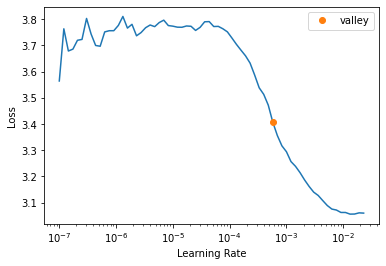

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(30,6e-04) #Set_6

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,3.397034,2.166391,0.210207,00:11


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.994909,2.041799,0.259125,00:11
1,1.946091,1.947430,0.297820,00:10
2,1.851875,1.930024,0.346857,00:10
3,1.790546,1.851295,0.382901,00:10
4,1.736660,1.866376,0.380446,00:10
5,1.676223,1.902978,0.356325,00:10
6,1.629265,1.842857,0.400665,00:10
7,1.587267,1.871426,0.402307,00:10
8,1.575598,2.030042,0.370009,00:10
9,1.567969,2.055104,0.385547,00:10


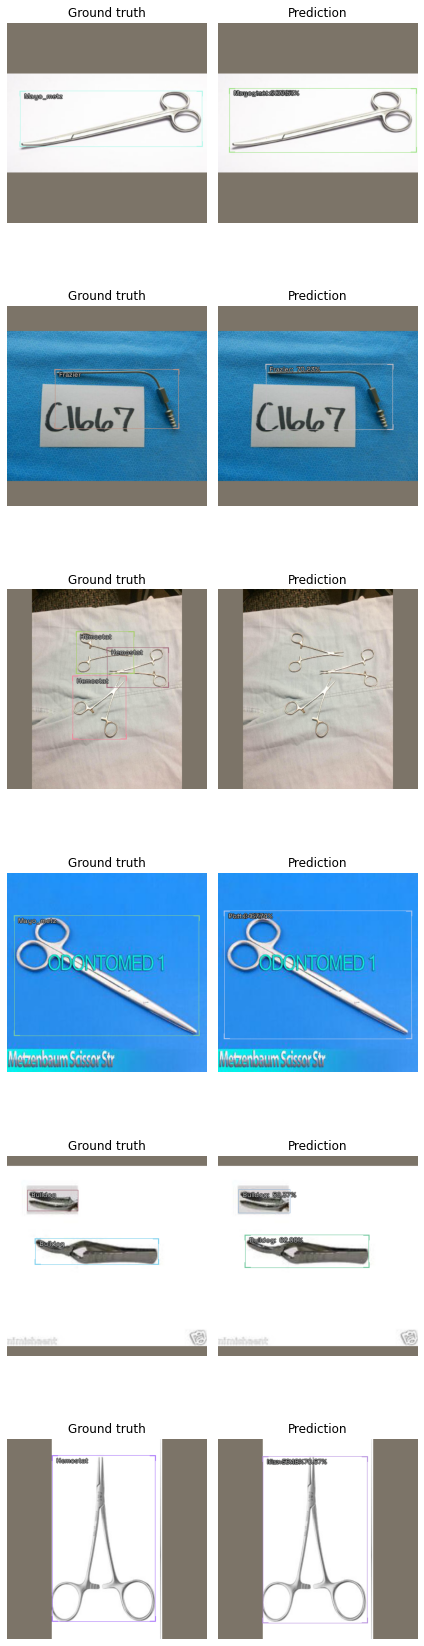

In [ ]:
model_type.show_results(model, valid_ds, )  #Set_6

**One-time Training**

**Sets 1-6 merged to Set_S**

In [ ]:
!ls gdrive/MyDrive/Surgical_instruments/Set_1_6b.v1i.coco

README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
# revised annotation file to remove extra class Mayo-metz
path = Path('gdrive/MyDrive/Surgical_instruments/Set_1_6b.v1i.coco') 

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',##
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

In [ ]:
# same classes, sizes and transformations
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
# use COCO-pretrained model
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map),)# **extra_args)

In [ ]:
# same metric and model structure
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,##
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,##
                               shuffle=False)

In [ ]:
wandb.init(project = 'Transfer_learning_vf', name = 'One-time', ##
           reinit = True)

COCOMetric,▁▃▄▅▆▅▆▆▇▇▇▇▇▇████▇█▃▄▅▆▆▆▆▄▅▆▅▅▆▃▅▅▅▅▅▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▁█▂▃▃▃▂▁▁
lr_1,▁▃▃▃▂▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▂▂▁▁▁▂▃▄▄▂▁█▃▅▅▄▃▂▁


In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.010964781977236271)

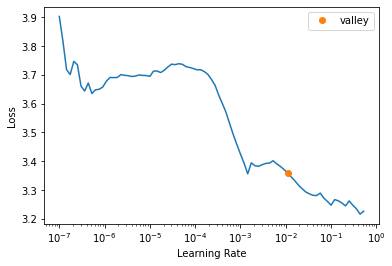

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(30,1e-02) ##

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,2.966373,3.234059,0.000000,00:38


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,2.532043,2.283020,0.018621,00:44
1,2.266648,2.248610,0.038780,00:43
2,2.195991,2.369684,0.039410,00:43
3,2.162219,2.279669,0.031140,00:43
4,2.146435,2.269346,0.039222,00:44
5,2.136787,2.238444,0.040541,00:43
6,2.143288,2.317868,0.036571,00:43
7,2.126037,2.371777,0.047132,00:43
8,2.113966,2.270363,0.037092,00:43
9,2.109138,2.168791,0.050372,00:43


In [ ]:
learn.fine_tune(30, 1e-02) #60

Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.730890,2.410069,0.131197,00:40


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.748894,2.042711,0.169718,00:43
1,1.679963,2.020001,0.188694,00:43
2,1.675183,2.022676,0.201282,00:43
3,1.672822,2.082604,0.172482,00:43
4,1.719317,2.085552,0.169482,00:43
5,1.790222,2.047444,0.119628,00:43
6,1.789831,2.060127,0.146738,00:43
7,1.799626,2.060515,0.158598,00:43
8,1.815468,2.063793,0.167301,00:43
9,1.824560,2.073878,0.177293,00:43


In [ ]:
learn.fine_tune(30, 1e-02) #90

Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.539205,2.243579,0.223561,00:40


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.490080,1.989995,0.270692,00:43
1,1.436033,1.916754,0.297895,00:42
2,1.438066,2.003687,0.278227,00:43
3,1.459203,1.989733,0.257930,00:42
4,1.487149,2.016545,0.240618,00:42
5,1.531758,2.063515,0.231127,00:43
6,1.565172,2.187832,0.215999,00:43
7,1.603168,2.042904,0.228860,00:43
8,1.634118,1.991306,0.208629,00:43
9,1.610978,2.066807,0.199892,00:43


In [ ]:
learn.fine_tune(30, 1e-02) #120

Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.274375,2.310641,0.228523,00:40


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.296967,2.109074,0.301880,00:42
1,1.274810,2.078224,0.333179,00:42
2,1.254033,2.148908,0.307416,00:42
3,1.267866,2.175328,0.282997,00:42
4,1.337774,2.275895,0.249074,00:42
5,1.402468,1.979975,0.303958,00:42
6,1.401477,2.037352,0.298502,00:43
7,1.462321,2.230857,0.207713,00:42
8,1.463986,2.040483,0.289878,00:43
9,1.542208,1.967251,0.268461,00:43


In [ ]:
learn.fine_tune(30, 1e-02) #150

Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.216630,2.273584,0.284669,00:39


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.198527,2.004369,0.361746,00:42
1,1.161789,2.003338,0.367695,00:42
2,1.126952,2.035066,0.391082,00:42
3,1.150784,2.121525,0.340800,00:43
4,1.214699,2.320213,0.324951,00:42
5,1.273239,2.192966,0.279353,00:43
6,1.291556,2.152782,0.298683,00:42
7,1.374041,2.062618,0.309834,00:43
8,1.407392,2.146472,0.313335,00:42
9,1.416497,2.019584,0.329617,00:43


In [ ]:
learn.fine_tune(30, 1e-02) #180

Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.095545,2.313024,0.349350,00:39


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.114429,1.975219,0.398435,00:43
1,1.045728,1.992127,0.404768,00:42
2,1.041298,2.074012,0.361580,00:42
3,1.028126,2.194360,0.373665,00:42
4,1.081167,2.043985,0.338484,00:42
5,1.138379,2.126727,0.360282,00:42
6,1.202842,2.127813,0.365654,00:42
7,1.261950,2.174995,0.337062,00:43
8,1.287467,2.538005,0.277189,00:42
9,1.331851,2.178922,0.309672,00:42


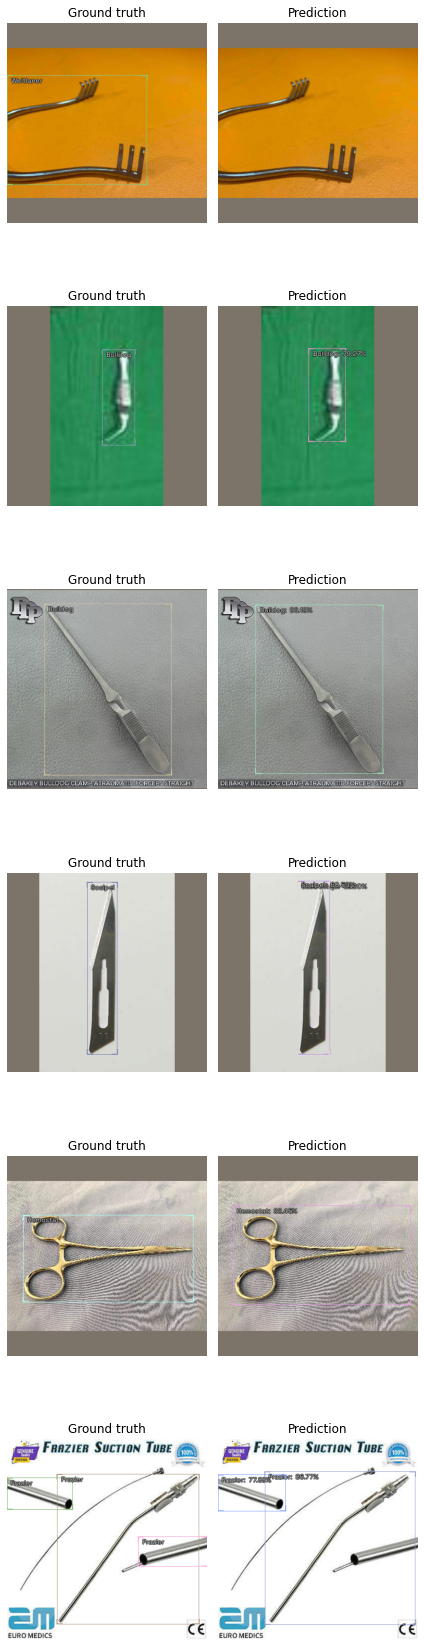

In [ ]:
model_type.show_results(model, valid_ds)

Using one long train run

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map))

In [ ]:
# same metric and model structure
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,##
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,##
                               shuffle=False)

In [ ]:
wandb.init(project = 'Transfer_learning_vf', name = 'One-time_long', ##
           reinit = True)

COCOMetric,▁▁▁▂▃▃▄▄▃▃▄▄▆▆▅▄▅▅▆▆▆▆▅▆▆▇▇▇▆▆▆██▆▇▆▆▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
lr_1,▁▂▂▂▂▁▁▁▂▂▂▁▁▃▂▂▂▂▁▁▁▂▂▂▁▁▁▁▂▂▂▁▁█▂▂▂▂▁▁


In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback())

In [ ]:
learn.fine_tune(180, 1e-02) # using same lr as the interrupted run0

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,2.775737,2.551377,0.025260,00:40


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,2.205140,2.208075,0.041831,00:44
1,2.128709,2.162162,0.064350,00:44
2,2.090785,2.270490,0.054738,00:43
3,2.052231,2.158471,0.067554,00:43
4,2.022786,2.139736,0.059409,00:44
5,2.006129,2.098258,0.062139,00:43
6,1.973218,2.186352,0.065692,00:43
7,1.944572,2.145418,0.077806,00:43
8,1.948549,2.104623,0.090436,00:43
9,1.904754,2.130148,0.100196,00:43


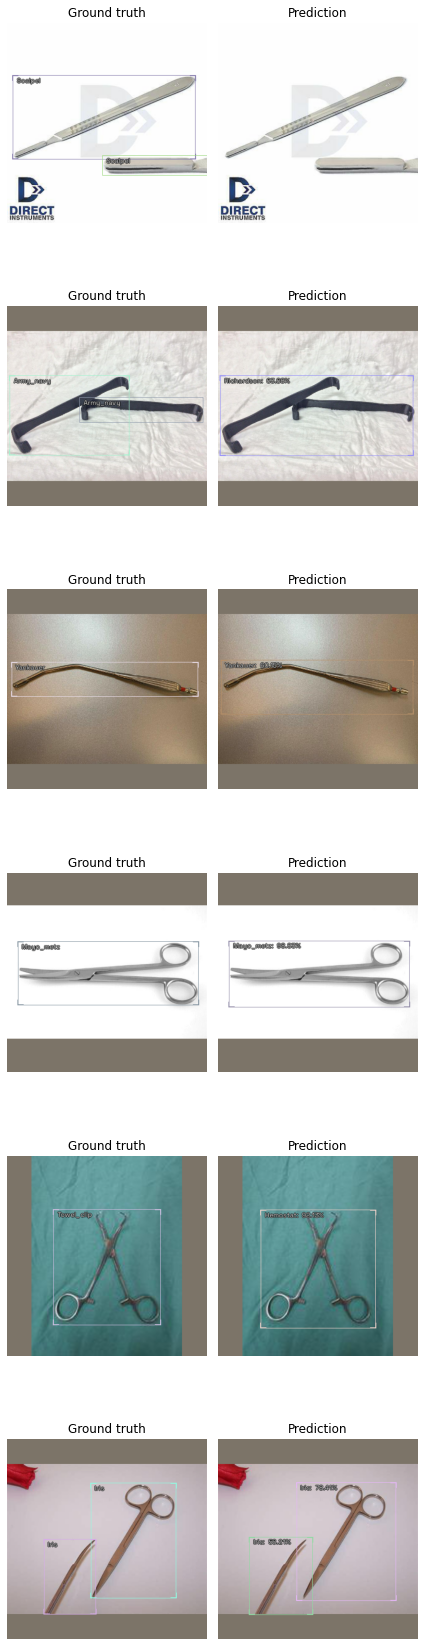

In [ ]:
model_type.show_results(model, valid_ds) #Set_1_6 one long run

In [ ]:
# colab not showing files
# temporary way of uploading:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
# temporary
from google.colab import files
files.download(checkpoint_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>